# Facial Keypoints Detection
- Jan Burian
- https://www.kaggle.com/competitions/facial-keypoints-detection/overview

## Modules import

In [16]:
import numpy as np
from pathlib import Path 
import os
import math
import pandas as pd
import json 
import matplotlib.pyplot as plt
from PIL import Image

import wandb

from sklearn.model_selection import train_test_split 

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from albumentations.pytorch import ToTensorV2
import albumentations as A

from datetime import datetime
import random

## Preparing data

In [2]:
data_directory = Path('./data/facial-keypoints-detection')
BASE_directory = os.path.join(os.getcwd(), data_directory)
!pwd # current working directory
print(BASE_directory)

/auto/brno2/home/jburian/ondemand
/auto/brno2/home/jburian/ondemand/data/facial-keypoints-detection


In [74]:
# Training data
train_csv = pd.read_csv(os.path.join(BASE_directory, 'training', 'training.csv'))
train_csv.T # Transposed for better visualization

,0,1,2,3,4,5,6,7,8,9,...,7039,7040,7041,7042,7043,7044,7045,7046,7047,7048
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301,69.680748,64.131866,67.468893,65.80288,64.121231,...,69.229935,63.352951,65.711151,67.929319,66.867222,67.402546,66.1344,66.690732,70.965082,66.938311
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261,39.968748,34.29004,39.413452,34.7552,36.740308,...,38.575634,35.671311,38.843545,35.846552,37.356855,31.842551,38.365501,36.845221,39.853666,43.42451
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481,29.183551,29.578953,29.355961,27.47584,29.468923,...,29.407912,33.952078,32.268751,28.68782,30.750926,29.746749,30.478626,31.66642,30.543285,31.096059
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032,37.563364,33.13804,39.621717,36.1856,38.390154,...,38.34545,40.816448,37.706043,41.452484,40.115743,38.632942,39.950198,39.685042,40.772339,39.528604
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589,62.864299,57.797154,59.554951,58.65216,58.620923,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261,40.169271,35.15404,40.454773,37.32928,37.840615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926,76.898243,69.026577,75.591612,72.95296,71.272,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466,41.171888,34.29004,40.038245,35.89952,37.290338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238,36.401047,34.761664,37.478214,36.3424,36.344615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852,39.367626,33.71404,40.454773,37.0432,39.490462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
# Test data
test_csv = pd.read_csv(os.path.join(BASE_directory, 'test', 'test.csv'))
test_csv.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


## Training data visualization

In [39]:
# Function to plot image with keypoints
def plot_image_with_keypoints(ax, image_data, keypoints, idx):
    img = np.array(image_data['Image'].split(), dtype='uint8')
    img = img.reshape((96, 96))

    # Plot the image
    ax.imshow(img, cmap='gray')

    # Plot keypoints
    for i in range(0, len(keypoints), 2):
        x, y = keypoints[i], keypoints[i + 1]
        ax.scatter(x, y, color='red', marker='+')
        ax.set_title(f"Image ID: {idx}")

    ax.axis('off')
    
def visualize_image_data(number_of_images):
    fig, axes = plt.subplots(1, number_of_images, figsize=(15, 3))
    for i in range(number_of_images):
        idx = random.randint(0,len(train_csv))
        image_data = train_csv.iloc[idx]
        keypoints = image_data[:-1]  # Exclude the last column (Image)
        plot_image_with_keypoints(axes[i], image_data, keypoints, idx)

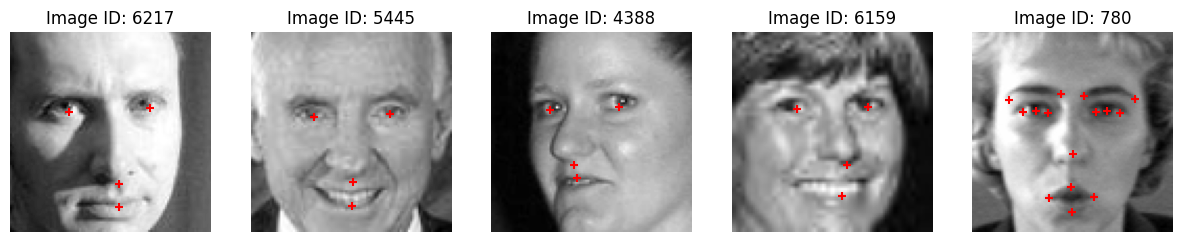

In [40]:
num_images = 5 # number of images to be visualized with keypoints
visualize_image_data(num_images)

## Keypoints statistics

In [96]:
def get_keypoint_count_dictionary():
    keypoint_count_dictionary = {}

    for keypoint_name in train_csv.columns:
        if keypoint_name == "Image":
            continue

        keypoint_data = train_csv[keypoint_name]

        # Check for non-numeric values and NaN
        valid_keypoint_data = keypoint_data[pd.to_numeric(keypoint_data, errors='coerce').notna()]

        # Count the number of valid values
        num_valid_keypoint_data = len(valid_keypoint_data)

        # Store the count in the dictionary with the keypoint name as the key
        keypoint_count_dictionary[keypoint_name] = num_valid_keypoint_data
    
    return keypoint_count_dictionary

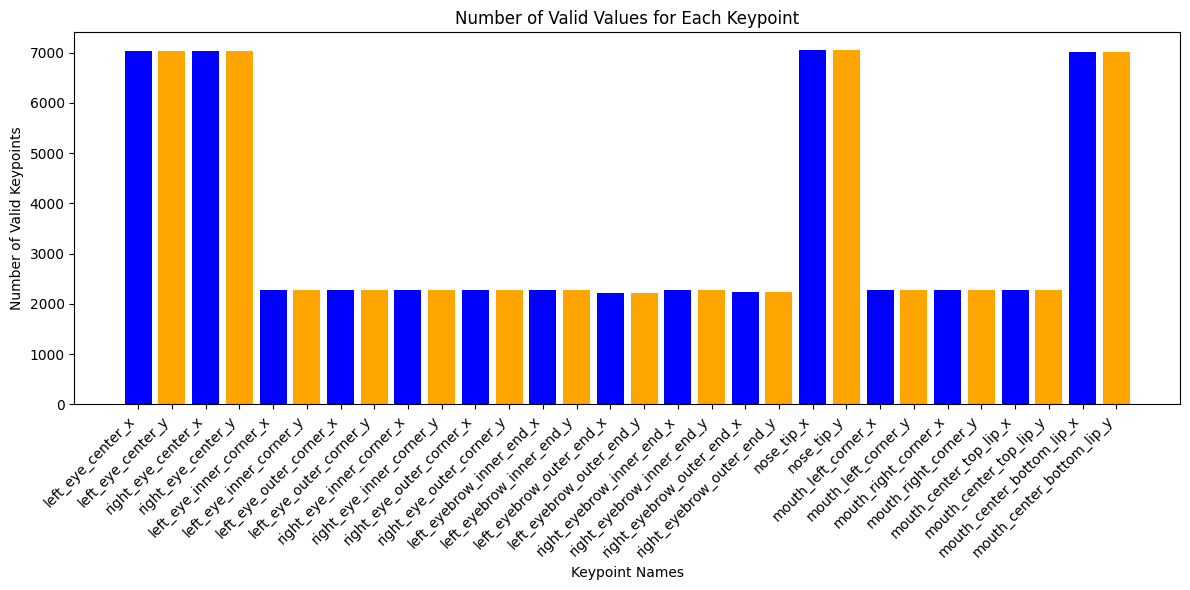

In [102]:
def visualize_num_valid_keypoints(keypoint_count_dictionary: dict):
    # Extract keypoint names and corresponding counts
    keypoint_names = list(keypoint_count_dictionary.keys())
    keypoint_counts = list(keypoint_count_dictionary.values())

    # Create a list of colors for neighboring bars
    bar_colors = ['blue' if i % 2 == 0 else 'orange' for i in range(len(keypoint_names))]

    # Create a histogram with alternating colors for neighboring bars
    plt.figure(figsize=(12, 6))
    plt.bar(keypoint_names, keypoint_counts, color=bar_colors)
    plt.xlabel('Keypoint Names')
    plt.ylabel('Number of Valid Keypoints')
    plt.title('Number of Valid Values for Each Keypoint')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()

    # Show the plot
    plt.show()
    
keypoint_count_dictionary = get_keypoint_count_dictionary()
visualize_num_valid_keypoints(keypoint_count_dictionary)

In [103]:
## TODO: do something with NaN values 

## Dataset

In [126]:
class FaceKeypointsDataset(Dataset):
    def __init__(self, img_data_frame: pd, keypoints_data_frame: pd, train=True, transform=None):
        self.img_data_frame = img_data_frame
        self.keypoints_data_frame = keypoints_data_frame
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.img_data_frame)

    def __getitem__(self, idx):
        image_data = self.img_data_frame.iloc[idx]
        image = np.array(image_data['Image'].split(), dtype='uint8')
        
        if self.train:
            keypoints = self.keypoints_data_frame.iloc[idx]
        else:
            keypoints = None
            
        sample = {'image': image, 
                  'keypoints': keypoints}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

### Augmentations

In [127]:
# resize_dimension = (96, 96)
# transform = A.Compose([
#     A.Resize(width = resize_dimension[0], height = resize_dimension[1]),
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
#     ToTensorV2(),
# ])

### Preparing dataset

In [128]:
# Parameters
batch_size = 64 # number of samples for training
num_workers = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split train dataset into 2 parts (train set + validation set)
# Specify the features (X) and target variable (y)
X = train_csv.drop('Image', axis=1)  # Keypoints
y = train_csv['Image'] # Image

# Split the data into training and validation sets (80 % training set + 20 % validation set)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Test set (created from test.csv)
X_test = pd.DataFrame() # No keypoints -> empty dataframe
y_test = test_csv['Image']

# Display the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_train shape:", y_train.shape)
print("y_valid shape:", y_valid.shape)
print("y_test shape:", y_test.shape)

print(type(X_train))

X_train shape: (5639, 30)
X_valid shape: (1410, 30)
y_train shape: (5639,)
y_valid shape: (1410,)
y_test shape: (1783,)
<class 'pandas.core.frame.DataFrame'>


In [129]:
# Getting train, val and test datasets
train_dataset = FaceKeypointsDataset(
    keypoints_data_frame=y_train,
    img_data_frame=X_train,
    train=True,
    transform=None
)


val_dataset = FaceKeypointsDataset(
    keypoints_data_frame=y_valid,
    img_data_frame=X_valid,
    train=True,
    transform=None
)


test_dataset = FaceKeypointsDataset(
    keypoints_data_frame=y_test,
    img_data_frame=X_test,
    train=False,
    transform=None
)

### Dataloader

In [130]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True, 
)


val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)


test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)


loaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

# print(len(x_train))
# print(len(y_train))
# print(len(x_val))
# print(len(y_val))
# print(len(x_test))
# print(len(y_test))

### Dataset size

In [131]:
print(f"Train set size: {len(train_loader.dataset)} images.")
print(f"Validation set size: {len(val_loader.dataset)} images.")
print(f"Test set size: {len(test_loader.dataset)} images.\n")

print(f"Dataset size: {np.sum([len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)])} images.")

Train set size: 5639 images.
Validation set size: 1410 images.
Test set size: 0 images.

Dataset size: 7049 images.


## Visualizing training data

from train_loader

In [132]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # denormalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Image'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/var/tmp/pbs.18941262.meta-pbs.metacentrum.cz/ipykernel_395648/1065089001.py", line 13, in __getitem__
    image = np.array(image_data['Image'].split(), dtype='uint8')
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/series.py", line 981, in __getitem__
    return self._get_value(key)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/series.py", line 1089, in _get_value
    loc = self.index.get_loc(label)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    raise KeyError(key) from err
KeyError: 'Image'


## Usage of a pretrained model

In [133]:
from torchvision import models

In [134]:
dir(models) # available models and weights from torchvision

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

### W&B setup

In [136]:
# W&B login
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: janburian. Use `wandb login --relogin` to force relogin


True

In [137]:
def create_actual_timestamp():
    current_time = datetime.now()
    time_string = current_time.strftime("%Y%m%d%H%M%S")
    
    return time_string

In [138]:
# Initialize W&B
wandb.init( # set the wandb project where this run will be logged
    project = "facial_keypoints_detection",
    name = "test", # TODO

    # track hyperparameters and run metadata
    config = {
        "learning_rate": 1e-4,
        "batch_size": batch_size, 
        "architecture": "",
        "dataset": "Facial keypoints detection",
        "num_epochs": 20,
        "dropout": 0.7,
        "device": device,
        "timestamp": create_actual_timestamp(),
    }
)


# Copy config
config = wandb.config